In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
!pip install keras

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [48]:
train_dir = '/content/drive/Colab/BW/Data/Train'
validation_dir = '/content/drive/Colab/BW/Data/Validation'
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                rescale=1./255,
                width_shift_range=0.09,
                height_shift_range=0.18,
                shear_range=0.15,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(256, 256),
                batch_size=128,
                class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
                validation_dir,
                target_size=(256, 256),
                batch_size=128,
                class_mode='categorical')

Found 154 images belonging to 4 classes.
Found 19 images belonging to 4 classes.


In [49]:
from keras import layers
from keras import models
from keras import applications
model = models.Sequential()
conv_base = applications.VGG16(weights='imagenet', 
                               include_top=False, 
                               input_shape=[256, 256, 3]) 
conv_base.trainable = False
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

from keras import optimizers
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              33555456  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 2052      
Total para

In [53]:
from keras import callbacks
mc = callbacks.ModelCheckpoint('/content/drive/Colab/BW/weights{epoch:08d}.h5', 
                                     save_weights_only=True, period=10)
history = model.fit_generator(
                train_generator,
                steps_per_epoch=50,
                epochs=30,
                callbacks=[mc],
                validation_data=validation_generator,
                validation_steps=50
                )

Epoch 1/30
50/50 [==============================] - 77s 2s/step - loss: 1.1774 - acc: 0.4919 - val_loss: 0.9538 - val_acc: 0.5789
Epoch 2/30
50/50 [==============================] - 66s 1s/step - loss: 0.8682 - acc: 0.6541 - val_loss: 0.7515 - val_acc: 0.6316
Epoch 3/30
50/50 [==============================] - 66s 1s/step - loss: 0.7284 - acc: 0.7070 - val_loss: 0.6183 - val_acc: 0.7368
Epoch 4/30
50/50 [==============================] - 66s 1s/step - loss: 0.6316 - acc: 0.7423 - val_loss: 0.4955 - val_acc: 0.8421
Epoch 5/30
50/50 [==============================] - 66s 1s/step - loss: 0.5560 - acc: 0.7761 - val_loss: 0.4319 - val_acc: 0.8947
Epoch 6/30
50/50 [==============================] - 66s 1s/step - loss: 0.5053 - acc: 0.7968 - val_loss: 0.3642 - val_acc: 0.9474
Epoch 7/30
50/50 [==============================] - 68s 1s/step - loss: 0.4324 - acc: 0.8344 - val_loss: 0.2938 - val_acc: 0.9474
Epoch 8/30
50/50 [==============================] - 67s 1s/step - loss: 0.4122 - acc: 0.84

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


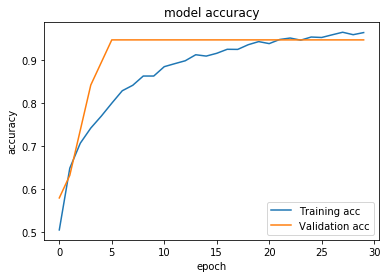

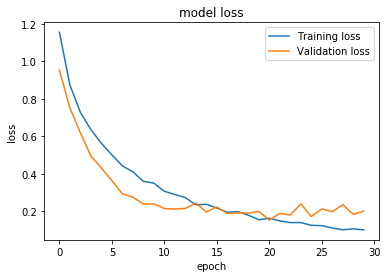

In [56]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'],label='Training acc')
plt.plot(history.history['val_acc'],label='Validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()